# [NLP trials](#nlp-trials)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import math
import os
from IPython.display import display
from random import sample
from time import time

import altair as alt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from dask.distributed import Client
from dask_ml.wrappers import ParallelPostFit
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS

/home/elstand/Downloads/nlp-space-news-topic-modeling/.tox/ci/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%aimport src.pipe_helpers
from src.pipe_helpers import (
    TextCleaner,
    StemTokenizer,
    NLTKLemmaTokenizer,
    SpacyLemmaTokenizer,
)

In [4]:
%aimport src.visualization_helpers
from src.visualization_helpers import (
    plot_horiz_bar,
    pipe_get_topics,
    get_main_topic_percentage,
    altair_datetime_heatmap,
)

In [5]:
SMALL_SIZE = 26
MEDIUM_SIZE = 28
BIGGER_SIZE = 30
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.facecolor"] = "white"
sns.set_style("darkgrid", {"legend.frameon": False})
sns.set_context("talk", font_scale=0.95, rc={"lines.linewidth": 2.5})

In [6]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
%matplotlib inline

<a id="toc"></a>

## [Table of Contents](#table-of-contents)
0. [About](#about)
1. [User Inputs](#user-inputs)
2. [Load joined data](#load-joined-data)
3. [Create analysis pipeline](#create-analysis-pipeline)
4. [Topic modeling](#topic-modeling)
5. [Exploring topics combined with source data](#exploring-topics-combined-with-source-data)

<a id="about"></a>

## 0. [About](#about)

In this notebook, we will experiment with NLP models on the joined news listings data in `data/processed/*_processed.csv`

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

We'll define below the variables that are to be used throughout the code.

In [7]:
PROJ_ROOT_DIR = os.path.abspath(os.getcwd())
processed_data_dir = os.path.join(PROJ_ROOT_DIR, "data", "processed")

In [8]:
# Dataset
publication_name = "guardian"

# Data locations
data_dir_path = os.path.join(processed_data_dir, f"{publication_name}_processed.csv")
cloud_run = True

# Custom stop words to include
manual_stop_words = ["nt", "ll", "ve"]

# Topic naming
mapping_dict = {
    "nytimes": {
        "component_1": "Academia",
        "component_2": "Shuttle Missions and Crashes",
        "component_3": "Digital",
        "component_4": "Mars Exploration",
        "component_5": "Imaging Stars - Astronomy",
        "component_6": "Rocket Launches - Testing and Moon Landing",
        "component_7": "Dark Matter theories",
        "component_8": "Planetary Research",
        "component_9": "Space Funding Bodies",
        "component_10": "ISS - USA and Russian segments",
        "component_11": "Gravity and Black Holes - Hawking",
        "component_12": "Global Warming",
        "component_13": "Studying Comets and Meteors",
        "component_14": "Soviet Union Spy Satellites",
        "component_15": "Discover of Sub-Atomic particles",
    },
    "guardian": {
        "component_1": "Academia",
        "component_2": "ISS - USA and Russian segments",
        "component_3": "Mars Exploration",
        "component_4": "Imaging Stars - Astronomy",
        "component_5": "Studying Comets and Meteors",
        "component_6": "Discover of Sub-Atomic particles",
        "component_7": "Rocket Launches - Moon Landing",
        "component_8": "Shuttle Missions and Crashes",
        "component_9": "Saturn Research",
        "component_10": "Space Funding Bodies",
        "component_11": "Objects crashing into Earth",
        "component_12": "Gravity and Black Holes - Hawking",
        "component_13": "Rocket Launches - Testing",
        "component_14": "Planetary Research",
        "component_15": "Global Warming",
    },
}

# General inputs
n_topics_wanted = 15
number_of_words_per_topic_to_show = 10

In [9]:
# Parameters
publication_name = "guardian"
cloud_run = True
manual_stop_words = ["nt", "ll", "ve"]
mapping_dict = {
    "nytimes": {
        "component_1": "Academia",
        "component_2": "Shuttle Missions and Crashes",
        "component_3": "Digital",
        "component_4": "Mars Exploration",
        "component_5": "Imaging Stars - Astronomy",
        "component_6": "Rocket Launches - Testing and Moon Landing",
        "component_7": "Dark Matter theories",
        "component_8": "Planetary Research",
        "component_9": "Space Funding Bodies",
        "component_10": "ISS - USA and Russian segments",
        "component_11": "Gravity and Black Holes - Hawking",
        "component_12": "Global Warming",
        "component_13": "Studying Comets and Meteors",
        "component_14": "Soviet Union Spy Satellites",
        "component_15": "Discover of Sub-Atomic particles",
    },
    "guardian": {
        "component_1": "Academia",
        "component_2": "ISS - USA and Russian segments",
        "component_3": "Mars Exploration",
        "component_4": "Imaging Stars - Astronomy",
        "component_5": "Studying Comets and Meteors",
        "component_6": "Discover of Sub-Atomic particles",
        "component_7": "Rocket Launches - Moon Landing",
        "component_8": "Shuttle Missions and Crashes",
        "component_9": "Saturn Research",
        "component_10": "Space Funding Bodies",
        "component_11": "Objects crashing into Earth",
        "component_12": "Gravity and Black Holes - Hawking",
        "component_13": "Rocket Launches - Testing",
        "component_14": "Planetary Research",
        "component_15": "Global Warming",
    },
}
n_topics_wanted = 15
number_of_words_per_topic_to_show = 10
data_dir_path = "/home/elstand/Downloads/nlp-space-news-topic-modeling/data/processed/guardian_processed.csv"


In [10]:
# Get stop words from all packages
# # NLTK
nltk_dir = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.isdir(nltk_dir) or cloud_run:
    nltk.download("punkt")
    nltk.download("wordnet")
    nltk.download("stopwords")
    nltk.download("averaged_perceptron_tagger")
nltk_stop_words = set(stopwords.words("english"))
# Spacy and sklearn
spacy_stop_words = STOP_WORDS
sklearn_stop_words = stop_words.ENGLISH_STOP_WORDS

# Assemble manual list of stop words
spacy_not_in_sklearn = set(spacy_stop_words) - set(sklearn_stop_words)
nltk_not_in_sklearn = set(nltk_stop_words) - set(sklearn_stop_words)
all_stop_words = set(
    list(set(sklearn_stop_words))
    + list(spacy_not_in_sklearn)
    + list(nltk_not_in_sklearn)
)

# Manually add to stop words
for manual_stop_word in manual_stop_words:
    all_stop_words.add(manual_stop_word)

[nltk_data] Downloading package punkt to /home/elstand/nltk_data...


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elstand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elstand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elstand/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<a id="load-joined-data"></a>

## 2. [Load joined data](#load-joined-data)

We'll start by loading the joined data from from a publication, stored at `data/processed/<publication-name>_processed.csv`, into a `DataFrame`

In [11]:
df = pd.read_csv(data_dir_path)
df = df[["text", "year"]]
print(df.shape[0])
display(df.head())
# print(corpus[0])

4148


,text,year
0,The second Russian satellite has demonstrated ...,1957
1,"Col. Glenn reported ""hale and hearty""Picked up...",1962
2,The entire three-man crew of the Apollo One sp...,1967
3,Russia's celebratory gesture in manned space f...,1967
4,Men are on the moon. At 3 39 a.m. this morning...,1969


In [12]:
corpus = df.loc[:, "text"].values.tolist()

Here, we will define a custom index to be used when defining the `DataFrame` of topics and documents

In [13]:
corpus_label = [t[:30] + "..." for t in corpus]

<a id="create-analysis-pipeline"></a>

## 3. [Create analysis pipeline](#create-analysis-pipeline)

Next, we'll define the various components of the NLP analysis pipeline

For a vectorizer, we will instantiate 3 options for tokenization
- `lemmatizer_vectorizer`
  - this will perform lemmatization using either the [NLTK module](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/) or [Spacy](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
- `stemmer_vectorizer`
  - this will perform stemming using [NLTK](http://www.nltk.org/howto/stem.html)
- `vectorizer`
  - this will use the string tokenization built in to [`scikit-learn`'s `TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [14]:
lemmatizer_vectorizer = TfidfVectorizer(
    tokenizer=NLTKLemmaTokenizer(
        stopwords=all_stop_words, clean=True, split=True, get_word_pos=True
    ),  # "all_stop_words" or "english"
    # tokenizer=SpacyLemmaTokenizer(stopwords=all_stop_words, clean=True, split=True),  # "all_stop_words" or "english"
    lowercase=True,
    strip_accents="ascii",
    token_pattern="[a-z][a-z]+",
)
stemmer_vectorizer = TfidfVectorizer(
    tokenizer=StemTokenizer(
        stype="snowball", stopwords=all_stop_words, clean=True, split=True
    ),  # "all_stop_words" or "english"
    lowercase=True,
    strip_accents="ascii",
    token_pattern="[a-z][a-z]+",
)
vectorizer = TfidfVectorizer(
    tokenizer=None,
    stop_words=all_stop_words,  # "all_stop_words" or "english"
    lowercase=True,
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=None,
    binary=False,
    strip_accents="ascii",
    token_pattern="[a-z][a-z]+",
)

Next, we will put these together into a `scikit-learn` Pipeline

In [15]:
# Pipeline without lemmatization or stemming
pipe = Pipeline(
    steps=[
        ("cleaner", TextCleaner(split=False)),
        ("vectorizer", vectorizer,),
        ("nmf", NMF(n_components=n_topics_wanted)),
    ]
)

# # Pipeline with lemmatization or stemming
# pipe = Pipeline(
#     steps=[
#         ("vectorizer", stemmer_vectorizer),  # with stemming and no lemmatization
#         # ("vectorizer", lemmatizer_vectorizer),  # with lemmatization and no stemming
#         ("nmf", NMF(n_components=n_topics_wanted)),
#     ]
# )

<a id="topic-modeling"></a>

## 4. [Topic modeling](#topic-modeling)

Next, we'll use the NLP analysis pipeline to retrieve topics from the corpus

There were 3 options to combine the assigned topics to the source `DataFrame` of documents
1. [Get](https://stackoverflow.com/a/38955314/4057186) top n-highest value columns, **sorted** by (highest) value, for each row
2. Get top-n highest value columns by threshold value (i.e. all those above a threshold value)
   - least prefered option because cutoff threshold is arbitrarily chosen
3. Get top-1 highest value column for each row
   - this was the chosen option for assigning values to the `all_topics` columns

Since this is a `scikit-learn` pipeline, We'll use parallelize the operation using [`dask` with `joblib`](https://examples.dask.org/machine-learning.html#Distributed-Training). We will instantiate a `dask` local cluster

In [16]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34523 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.23 GB


Next, we use a helper function to
- retrieve two `DataFrame`s that contain the topics
- generate a plot of topics and top 10 words (by how much each document is made up of the resulting topics) for each topic
- replace placeholder topic names by custom topic names

Cell exection time: 0 minutes, 51.42 seconds


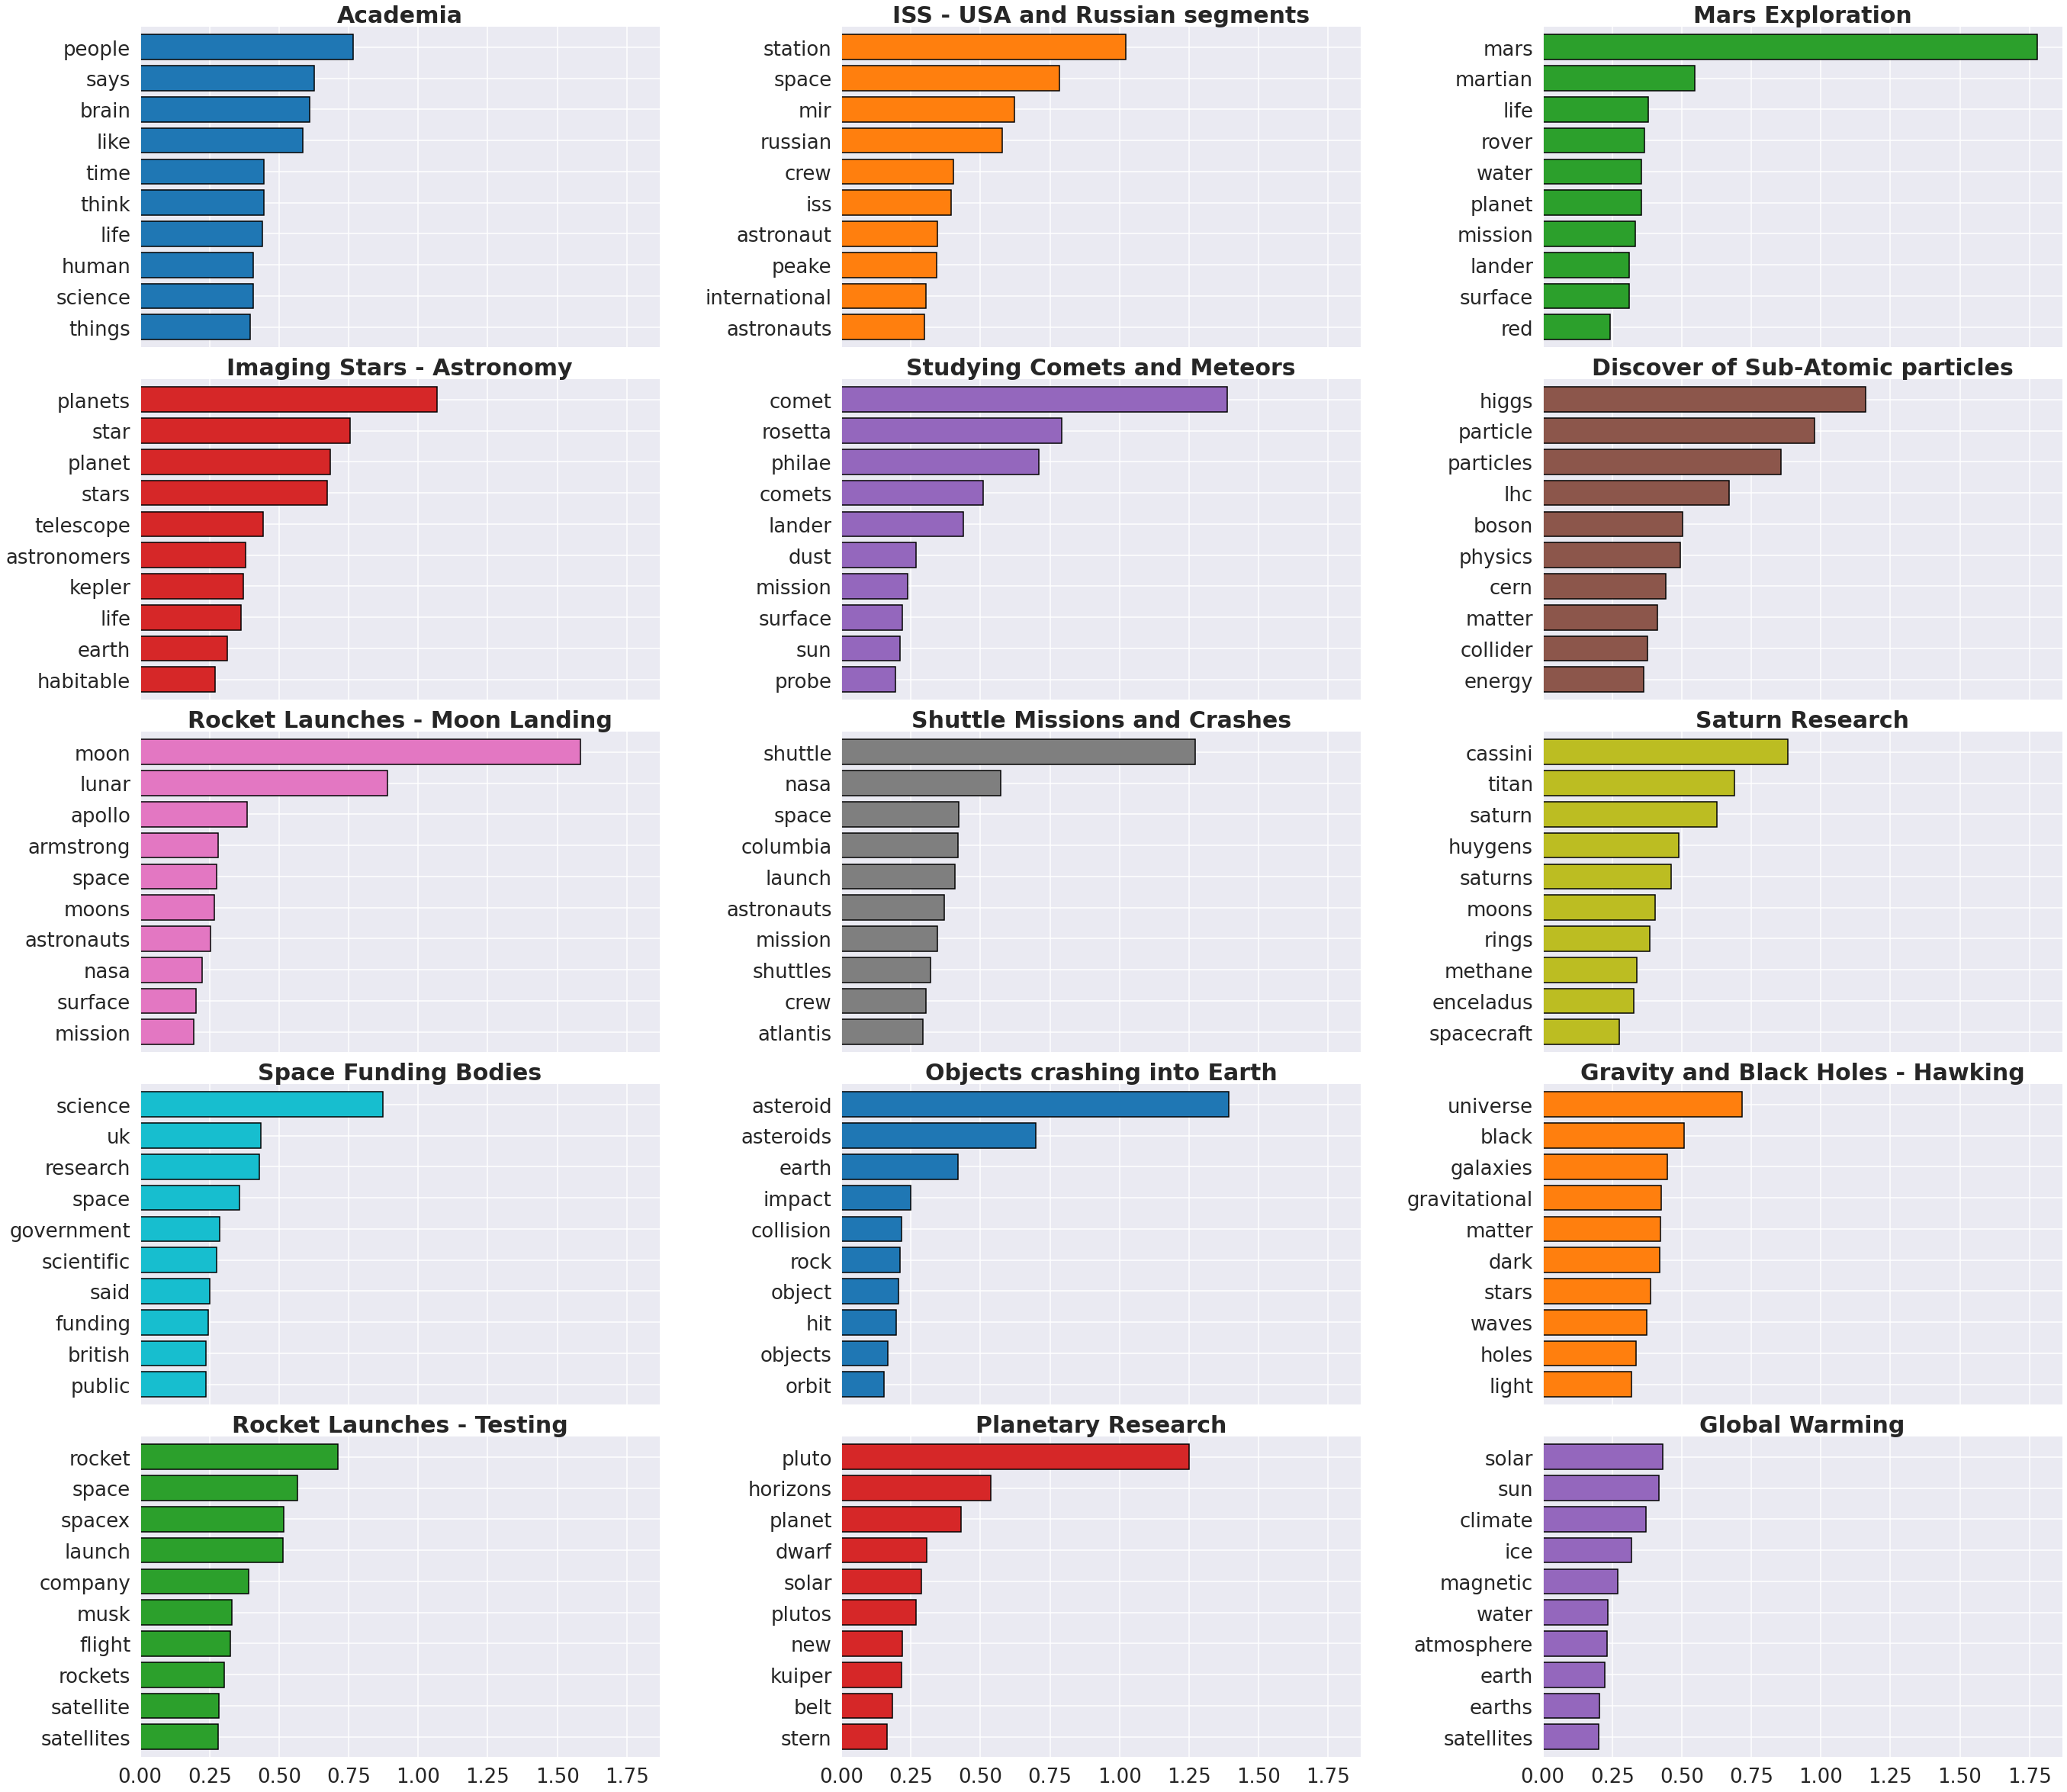

In [17]:
cell_st = time()

with joblib.parallel_backend("dask"):
    df_with_topics, df_source_with_topics, topic_word, fig = pipe_get_topics(
        corpus,
        pipe=pipe,
        n_topics_wanted=n_topics_wanted,
        df=df,
        y_tick_mapper_list=list(mapping_dict[publication_name].values()),
        vt_df_index=None,
        analysis_type="nmf",
        number_of_words_per_topic_to_show=number_of_words_per_topic_to_show,
        show_bar_labels=False,
    )

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Next, we'll close the `dask` cluster

In [18]:
client.close()

The figure showing words per topic is now optionally saved to a file

In [19]:
cell_st = time()

if not cloud_run:
    fig.savefig(
        os.path.join(PROJ_ROOT_DIR, "reports", "figures", f"{publication_name}_nmf_topics.png"),
        bbox_inches="tight",
        dpi=300,
    )

total_minutes, total_seconds = divmod(time() - cell_st, 60)
print(
    f"Cell exection time: {int(total_minutes):d} minutes, {total_seconds:.2f} seconds"
)

Cell exection time: 0 minutes, 0.00 seconds


In [20]:
display(df_with_topics.head(2))
display(df_source_with_topics.head(2))

,text,year,document,Academia,ISS - USA and Russian segments,Mars Exploration,Imaging Stars - Astronomy,Studying Comets and Meteors,Discover of Sub-Atomic particles,Rocket Launches - Moon Landing,Shuttle Missions and Crashes,Saturn Research,Space Funding Bodies,Objects crashing into Earth,Gravity and Black Holes - Hawking,Rocket Launches - Testing,Planetary Research,Global Warming,most_popular_topic
3469,The second Russian satellite has demonstrated ...,1957,The second Russian satellite h,0.050487,0.117678,0.0,0.005599,0.00000,0.020515,0.000000,0.000000,0.000000,0.0,0.045594,0.058062,0.411801,0.000000,0.290265,Rocket Launches - Testing
1061,"Col. Glenn reported ""hale and hearty""Picked up...",1962,"Col. Glenn reported ""hale and",0.043203,0.251861,0.0,0.009582,0.00077,0.004021,0.023441,0.149713,0.015485,0.0,0.003593,0.000000,0.405595,0.034049,0.058688,Rocket Launches - Testing


,year,most_popular_topic,all_most_popular_topics
0,1957,[component_13],Academia3
1,1962,[component_13],Academia3


Next, we'll show a summary `DataFrame` that summarizes the average number of times a topic was chosen as the most popular topic per `year`
- this will not be used in subsequent analysis but shows a summary of the topics by `year`

In [21]:
df_percentages = get_main_topic_percentage(
    df_with_topics.drop(["document"], axis=1),
    group_by_col="year",
    quant_col_idx_start=1,
)
df_percentages.head()

,Academia,ISS - USA and Russian segments,Mars Exploration,Imaging Stars - Astronomy,Studying Comets and Meteors,Discover of Sub-Atomic particles,Rocket Launches - Moon Landing,Shuttle Missions and Crashes,Saturn Research,Space Funding Bodies,Objects crashing into Earth,Gravity and Black Holes - Hawking,Rocket Launches - Testing,Planetary Research,Global Warming,most_popular_topic
year,,,,,,,,,,,,,,,,
1957,0.050487,0.117678,0.000000,0.005599,0.000000,0.020515,0.000000,0.000000,0.000000,0.000000,0.045594,0.058062,0.411801,0.000000,0.290265,Rocket Launches - Testing (41.18+/- nan)
1962,0.043203,0.251861,0.000000,0.009582,0.000770,0.004021,0.023441,0.149713,0.015485,0.000000,0.003593,0.000000,0.405595,0.034049,0.058688,Rocket Launches - Testing (40.56+/- nan)
1967,0.039085,0.333763,0.018562,0.000000,0.007760,0.003077,0.136660,0.089527,0.031406,0.005486,0.000000,0.002871,0.313038,0.005743,0.013024,ISS - USA and Russian segments (33.38+/- 9.75)
1969,0.048658,0.073953,0.019916,0.000000,0.071507,0.000000,0.592776,0.052154,0.015785,0.000000,0.032339,0.008104,0.034687,0.024533,0.025588,Rocket Launches - Moon Landing (59.28+/- 6.69)
1970,0.025369,0.110286,0.035665,0.000000,0.062679,0.000000,0.370608,0.192761,0.039805,0.000000,0.000000,0.000000,0.077062,0.000000,0.085766,Rocket Launches - Moon Landing (37.06+/- nan)


<a id="exploring-topics-combined-with-source-data"></a>

## 5. [Exploring topics combined with source data](#exploring-topics-combined-with-source-data)

Here, we will show a heatmap of the most popular topic by year

In [22]:
topics_by_timeframe = (
    df_with_topics.groupby(["most_popular_topic", "year"])
    .size()
    .reset_index()
    .sort_values(by=["most_popular_topic", 0, "year"], ascending=False)
    .rename(columns={0: "count"})
)
topics_by_timeframe.head()

,most_popular_topic,year,count
305,Studying Comets and Meteors,2014,31
306,Studying Comets and Meteors,2015,20
307,Studying Comets and Meteors,2016,11
299,Studying Comets and Meteors,2005,9
300,Studying Comets and Meteors,2006,8


In [23]:
altair_datetime_heatmap(
    topics_by_timeframe,
    x="year:O",
    y="most_popular_topic:N",
    xtitle="Year",
    ytitle="Most popular topic",
    tooltip=[
        {"title": "Year", "field": "year", "type": "ordinal",},
        {
            "title": "Most popular topic",
            "field": "most_popular_topic",
            "type": "nominal",
        },
        {
            "title": "Number of occurrences as main topic",
            "field": "count",
            "type": "quantitative",
        },
    ],
    cmap="yelloworangered",
    legend_title="",
    color_by_col="count:Q",
    yscale="log",
    axis_tick_font_size=12,
    axis_title_font_size=16,
    title_font_size=20,
    legend_fig_padding=10,  # default is 18
    y_axis_title_alignment="left",
    fwidth=700,
    fheight=450,
    file_path=os.path.join(PROJ_ROOT_DIR, "reports", "figures", "my_heatmap.html"),
    save_to_html=False,
    sort_y=[],
    sort_x=[],
)

alt.LayerChart(...)

Next, we will show a bar chart of the number of occurrences of the `"Space Funding Bodies"` as the most popular topic, relative to the year 1980
- this will approximate the public interest in changes in this topic over the years investigated

In [24]:
funds = (
    topics_by_timeframe[
        topics_by_timeframe["most_popular_topic"] == "Space Funding Bodies"
    ]
    .set_index("year")["count"]
    .sort_index()
)
funds / funds.loc[funds.index.min()]
funds = funds / funds.loc[funds.index.min()]

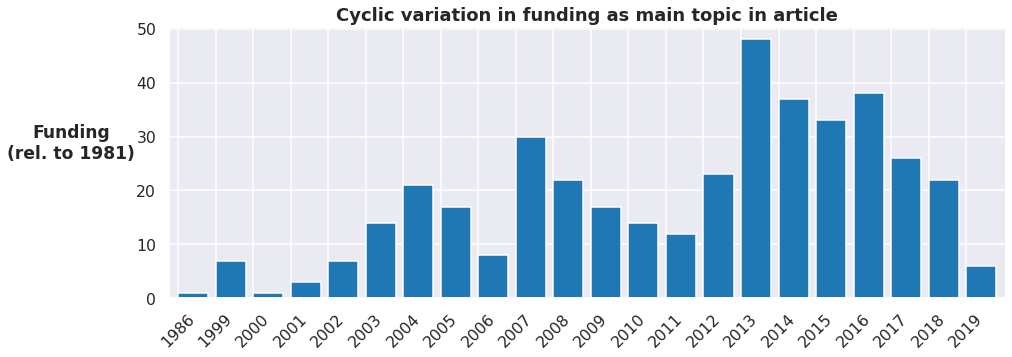

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
funds.plot(kind="bar", ax=ax, rot=45, align="edge", width=0.8)
ax.set_title(
    "Cyclic variation in funding as main topic in article",
    fontsize=18,
    fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Funding\n(rel. to 1981)", labelpad=65, fontweight="bold")
h.set_rotation(0)

Next, we will show a bar chart of the number of words in the `"text"` of the article
- this will approximate the length of articles over the years investigated

In [26]:
df["article_chars"] = df["text"].str.split().str.len()
word_count = df[["article_chars", "year"]].groupby(["year"])["article_chars"].sum()

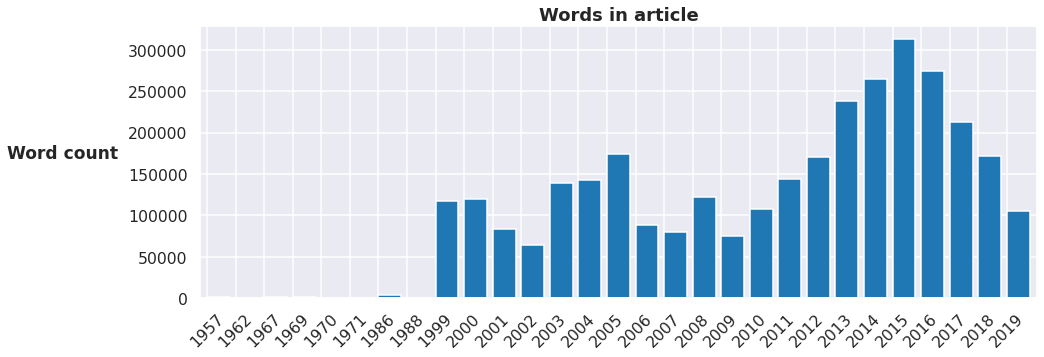

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
word_count.plot(kind="bar", ax=ax, rot=45, align="edge", width=0.8)
ax.set_title(
    "Words in article", fontsize=18, fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Word count", labelpad=65, fontweight="bold")
h.set_rotation(0)

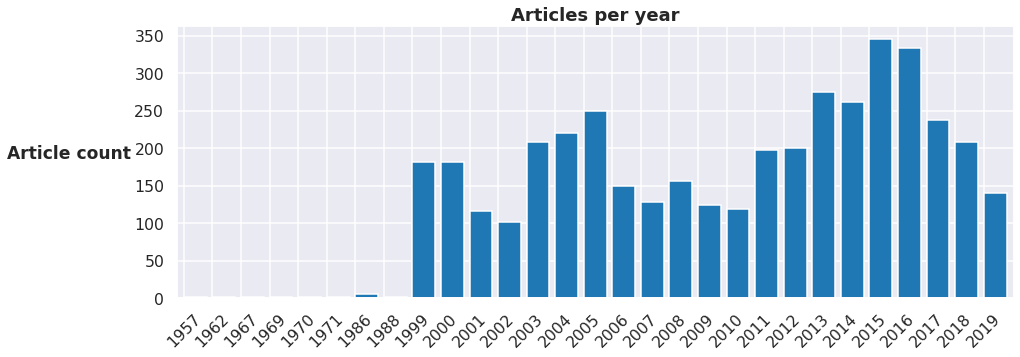

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
df["year"].value_counts().sort_index().plot(
    kind="bar", ax=ax, rot=45, align="edge", width=0.8
)
ax.set_title(
    "Articles per year", fontsize=18, fontweight="bold",
)
ax.set_xlabel(None)
h = plt.ylabel("Article count", labelpad=65, fontweight="bold")
h.set_rotation(0)

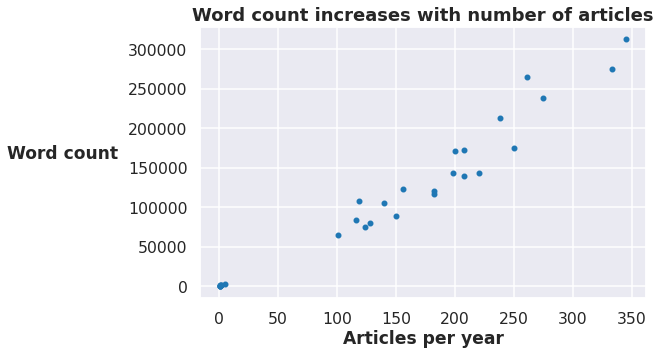

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
pd.DataFrame(word_count).merge(
    pd.DataFrame(df["year"].value_counts()),
    how="inner",
    left_index=True,
    right_index=True,
).plot.scatter(x="year", y="article_chars", ax=ax)
ax.set_title(
    "Word count increases with number of articles", fontsize=18, fontweight="bold",
)
ax.set_xlabel("Articles per year", fontweight="bold")
h = plt.ylabel("Word count", labelpad=65, fontweight="bold")
h.set_rotation(0)

For the New York Times, between 1981 and 2004, article length was fairly consistent. There was a significant drop in the years 2005 and 2012. Since 2013, article length has been steadily increasing.